# Magnitude Regularization

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

import time
import cPickle as pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Model baseline

In [2]:
batch_size = 32
global_step = 0
save_path = 'models/mag.ckpt'
xlen = 28*28
ylen = 10
reg_param = 1e-2

train_steps = 150000
info_every = 250
test_every = 1000

## Build model

In [3]:
#awn
tf.reset_default_graph()
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, xlen], name="x")
y_ = tf.placeholder(tf.float32, shape=[None, ylen], name="y_")
init = tf.truncated_normal_initializer(mean=0., stddev=.075, seed=1234, dtype=tf.float32)

reg = tf.contrib.layers.l2_regularizer(reg_param)
with tf.variable_scope("model", regularizer=reg):
    W = tf.get_variable("W", shape=[xlen,ylen], initializer=init)
output = tf.nn.softmax(tf.matmul(x, W))
sess.run(tf.initialize_all_variables())

In [4]:
loss = tf.nn.l2_loss( y_ - output ) / (ylen*batch_size) + sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.AdamOptimizer(1e-4)
grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables())
train_op = optimizer.apply_gradients(grads)

sess.run(tf.initialize_all_variables())

## Model overview

In [5]:
total_parameters = 0 ; print "Model overview:"
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "Total of {} parameters".format(total_parameters)

Model overview:
	variable "model/W:0" has 7840 parameters
Total of 7840 parameters


## Train

In [6]:
correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
loss_curve = np.zeros((train_steps/info_every, 2))
acc_curve = np.zeros((train_steps/test_every, 2))

begin = time.time()
for i in range(train_steps):
    batch_start = time.time()
    
    batch = mnist.train.next_batch(batch_size)
    feed = {x: batch[0], y_: batch[1]}
    train_loss, _ = sess.run([loss, train_op], feed_dict=feed)
    
    if i%test_every == 0:
        feed = {x: mnist.test.images, y_: mnist.test.labels}
        acc = accuracy.eval(feed_dict=feed)
        acc_curve[i/test_every,:] = [i, acc]
        print "{}/{}: test accuracy: {:3f}".format(i, train_steps, acc)
    if i%info_every == 0:
        loss_curve[i/info_every,:] = [i, train_loss]
        print "\tstep {}, loss {:3f}, batch time {:3f}".format(i, train_loss, time.time()-batch_start)
print "\ntotal runtime: {:3f} seconds".format(time.time()-begin)

0/150000: test accuracy: 0.084700
	step 0, loss 0.218412, batch time 0.058105
	step 250, loss 0.137189, batch time 0.000941
	step 500, loss 0.092095, batch time 0.000835
	step 750, loss 0.069516, batch time 0.001138
1000/150000: test accuracy: 0.669500
	step 1000, loss 0.051340, batch time 0.035001
	step 1250, loss 0.045199, batch time 0.000977
	step 1500, loss 0.038524, batch time 0.000857
	step 1750, loss 0.035479, batch time 0.000902
2000/150000: test accuracy: 0.735900
	step 2000, loss 0.043385, batch time 0.032951
	step 2250, loss 0.035790, batch time 0.001049
	step 2500, loss 0.037265, batch time 0.000968
	step 2750, loss 0.038070, batch time 0.000826
3000/150000: test accuracy: 0.762500
	step 3000, loss 0.039258, batch time 0.033585
	step 3250, loss 0.034151, batch time 0.002311
	step 3500, loss 0.035887, batch time 0.001069
	step 3750, loss 0.033572, batch time 0.000693
4000/150000: test accuracy: 0.759300
	step 4000, loss 0.037569, batch time 0.034111
	step 4250, loss 0.034852

In [8]:
feed = {x: mnist.test.images, y_: mnist.test.labels}
acc = accuracy.eval(feed_dict=feed)
print "final test accuracy: {:3f}".format(acc)

final test accuracy: 0.760100


## Plot performance

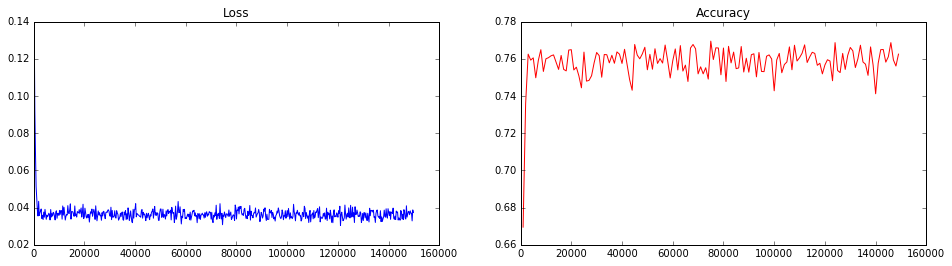

In [9]:
plt.figure(0, figsize=(16,4))
plt.subplot(121)
plt.title("Loss")
plt.plot(loss_curve[1:,0], loss_curve[1:,1], 'b-')
plt.subplot(122)
plt.title("Accuracy")
plt.plot(acc_curve[1:,0], acc_curve[1:,1], 'r-')

with open('mag.p', 'w') as f:
    pickle.dump(acc_curve, f)

## Plot weights

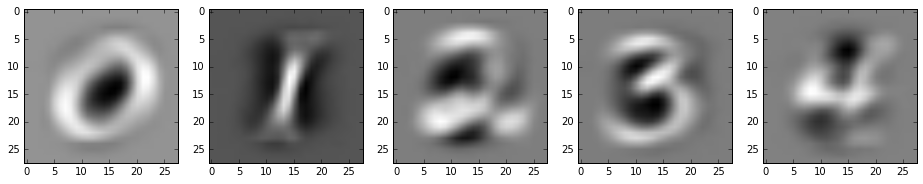

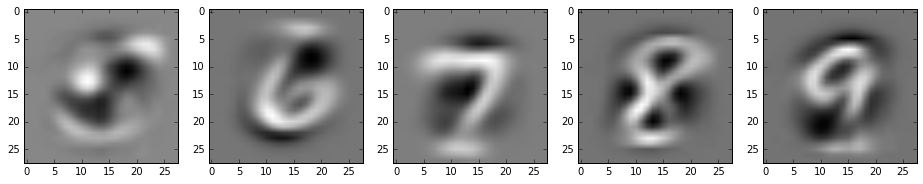

In [10]:
W_ = W.eval()
for i in range(0,10,5):
    img1 = np.reshape(W_[:,i], (28,28))
    img2 = np.reshape(W_[:,i+1], (28,28))
    img3 = np.reshape(W_[:,i+2], (28,28))
    img4 = np.reshape(W_[:,i+3], (28,28))
    img5 = np.reshape(W_[:,i+4], (28,28))
    plt.figure(i, figsize=(16,4))
    plt.subplot(151)
    plt.imshow(img1, cmap=cm.gray)
    plt.subplot(152)
    plt.imshow(img2, cmap=cm.gray)
    plt.subplot(153)
    plt.imshow(img3, cmap=cm.gray)
    plt.subplot(154)
    plt.imshow(img4, cmap=cm.gray)
    plt.subplot(155)
    plt.imshow(img5, cmap=cm.gray)

In [13]:
print np.min(W_), np.max(W_), "\n", W_

-0.0619026 0.0946954 
[[  1.41189802e-33  -2.71558067e-34   2.77273256e-33 ...,  -5.98029739e-33
    4.80621473e-33  -2.09940793e-33]
 [ -5.01382944e-33  -1.27191253e-33   5.65202737e-33 ...,  -6.67951302e-33
   -4.83996115e-34   5.75670367e-33]
 [ -2.23982000e-33   8.40886137e-33   1.56569750e-33 ...,  -1.39298927e-33
    1.78989990e-33   2.96610028e-33]
 ..., 
 [ -6.20390360e-33   1.54063972e-33  -4.06882309e-33 ...,   1.10184265e-33
   -1.23684965e-33  -1.85739954e-33]
 [  7.94016973e-33  -1.04011223e-32   1.47484987e-33 ...,   6.32552685e-33
    6.94731488e-33   6.15047922e-33]
 [ -2.32120663e-33  -5.60862114e-33   1.12356219e-32 ...,  -8.65693917e-33
    1.01942257e-32  -6.98584097e-33]]


## Saver IO

In [11]:
# saver = tf.train.Saver(tf.all_variables())
# load_was_success = True # yes, I'm being optimistic
# try:
#     save_dir = '/'.join(save_path.split('/')[:-1])
#     ckpt = tf.train.get_checkpoint_state(save_dir)
#     load_path = ckpt.model_checkpoint_path
#     saver.restore(sess, load_path)
# except:
#     print "no saved model to load. starting new session"
#     load_was_success = False
# else:
#     print "loaded model: {}".format(load_path)
#     saver = tf.train.Saver(tf.all_variables())
#     global_step = int(load_path.split('-')[-1])

In [12]:
# #fc 1 layer
# W1 = tf.get_variable("W1", shape=[xlen,ylen], initializer=init)
# b1 = tf.get_variable("b1", shape=[ylen], initializer=init)
# output = tf.nn.softmax(tf.matmul(x, W1) + b1)